# Integrated gradients for resenet model trained on Imagenet dataset

In this notebook we apply the integrated gradients method to a pretrained ResNet model trained on the imagenet data set.

The IntegratedGradients class implements the integrated gradients features attribution method. A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb). Integrated gradients was originally proposed in here [here](https://arxiv.org/abs/1703.01365).

In [6]:
import numpy as np
import os
import json
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from alibi.datasets import fetch_imagenet
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

TF version:  1.15.0
Eager execution enabled:  True


## Utility functions

Here we define some utility functions. The function `magnify_attrs` scales the values of the attributions for visualization porpuses. The function `plot_attributions` visualize the images and their attributions.

In [22]:
def plot_attributions(model, data, labels, attrs, label_idx_to_class_names, figsize=(20, 15), magnify_attrs=True):

    def magnify_attrs(attrs):
        return 3 * (attrs / attrs.max())
        
    ncols = 4
    nrows = 3
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    n_subplot = 1

    for i in [0, 1, 9]:
        X_i = data[i]
        #X_i = (X_i / 255).astype('float32')
        attrs_i = attrs[i]
        attrs_plus_i = attrs_i.copy()
        attrs_minus_i = -attrs_i.copy()
        attrs_plus_i[attrs_plus_i < 0] = 0
        attrs_minus_i[attrs_minus_i < 0] = 0
        
        if magnify_attrs:
            attrs_i = magnify_attrs(attrs_i)
            attrs_minus_i = magnify_attrs(attrs_minus_i)
            attrs_plus_i = magnify_attrs(attrs_plus_i)
        
        label = labels[i]
        label_name = label_idx_to_class_names[label]
        pred = np.argmax(model(X_i.reshape((1, ) + X_i.shape)).numpy(), axis=1)
        pred_name = label_idx_to_class_names[pred[0]]
        
        # original image
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0:
            plt.title('Original image. \n True label: {}. \n Model prediction: {}'.format(label_name, pred_name))
        else:
            plt.title('True label: {}. \n Model prediction: {}'.format(label_name, pred_name))
        
        plt.imshow(np.squeeze(X_i))
        n_subplot += 1
        
        # all attributions
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0:
            plt.title('All Attributions')
        plt.imshow(np.squeeze(attrs_i))
        n_subplot += 1

        # positive attributions
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0:
            plt.title('Positive Attributions')
        plt.imshow(np.squeeze(attrs_plus_i))
        n_subplot += 1

        # negative attributions
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0 :
            plt.title('Negative Attributions')
        plt.imshow(np.squeeze(attrs_minus_i))
        n_subplot += 1
   
    plt.show()

## Load data

Loading 10 images from the imagenet dataset, all belonging to the category "Persian cat". 

In [8]:
category = 'Persian cat'
image_shape = (224, 224, 3)
data, labels = fetch_imagenet(category, nb_images=10, target_size=image_shape[:2], seed=2, return_X_y=True)
print('Images shape: {}'.format(data.shape))
data = (data / 255).astype('float32')

Images shape: (10, 224, 224, 3)


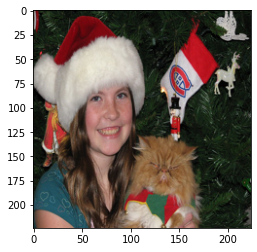

In [9]:
i = 1
plt.imshow(data[i]);

## Load model

Loading a pretrained tensorflow model with an ResNet architecture trained on the imagenet dataset.

In [10]:
model = ResNet50V2(weights='imagenet')

## Calculate integrated gradients

The IntegratedGradients class implements the integrated gradients features attributions method. A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb).

In the first example, the baselines (i. e. the starting points of the gradients' integral) are black images (all pixel's values are set to zero). This means that black areas of the image will always have zero attributions. In the second example we consider random uniform noise baselines. 
The path integral is defined as a straight line from the baseline to the input image. The path is approximated by choosing 50 discrete steps according to the Gauss-Legendre method.

In [24]:
n_steps = 50
method = "gausslegendre"
return_convergence_delta = True
return_predictions = False
ig  = IntegratedGradients(model,
                          n_steps=n_steps, 
                          method=method)

In [25]:
explanation = ig.explain(data, 
                         baselines=None, 
                         target=labels,
                         internal_batch_size=50,
                         return_convergence_delta=return_convergence_delta, 
                         return_predictions=return_predictions)

In [26]:
attrs = explanation.data['attributions']

## Visualize attributions

Sample images from the test dataset and their attributions.The attributions are scaled by an appropriate factor for visualization purposes. The first column alongside the image shows the raw values of the attributions. The second and the third columns show the pixels having positive values (second column) and negative values (third columns). Here, the attributions are calculated using the black image as a baseline for all samples.

In [27]:
with open("../alibi/data/imagenet_class_names_to_label_idx.json", 'r') as f:
    class_names_to_label_idx = json.load(f)
    f.close()
label_idx_to_class_names = {v: k for k, v in class_names_to_label_idx.items()}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


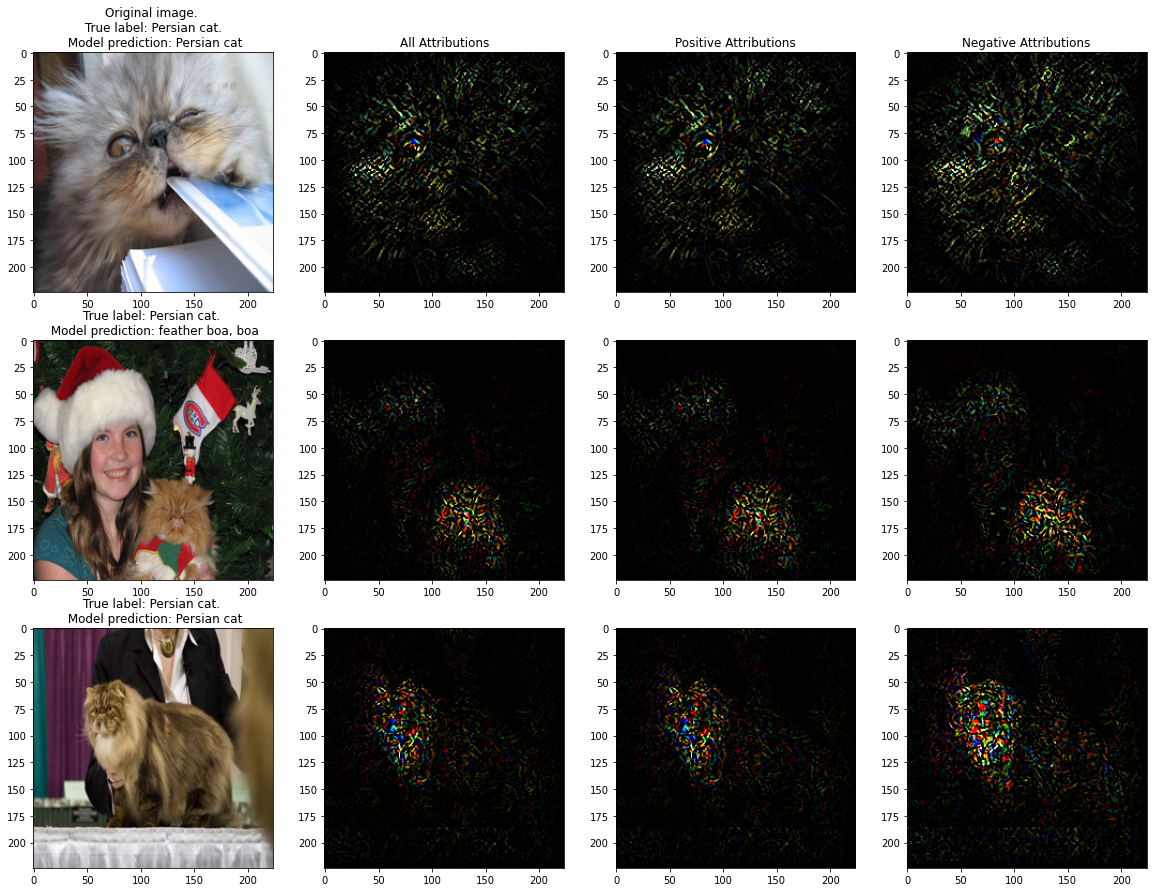

In [28]:
plot_attributions(model, data, labels, attrs, label_idx_to_class_names, figsize=(20, 15), magnify_attrs=True)

## Random baselines

Here we show the attributions obtained choosing random uniform noise as a baseline. It can be noticed that the attributions can be considerably different from the previous example. An exstensive discussion about the importance of the baselines in the integrated gradients method can be found [here](https://distill.pub/2020/attribution-baselines/).

In [29]:
baselines = np.random.random_sample(data.shape)

In [30]:
explanation = ig.explain(data, 
                         baselines=baselines, 
                         target=labels,
                         internal_batch_size=50,
                         return_convergence_delta=return_convergence_delta, 
                         return_predictions=return_predictions)

In [31]:
attrs = explanation.data['attributions']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


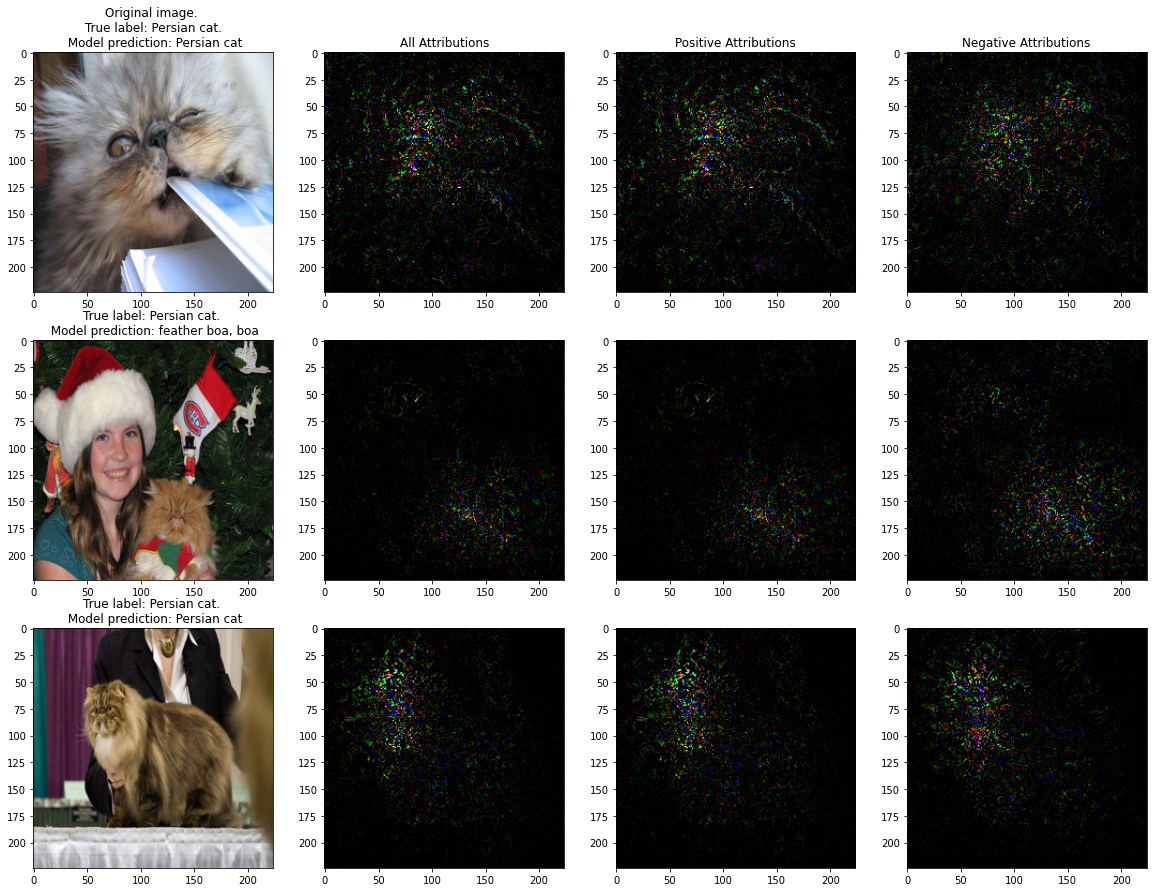

In [32]:
plot_attributions(model, data, labels, attrs, label_idx_to_class_names, figsize=(20, 15), )